In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
np.random()

TypeError: 'module' object is not callable

In [127]:
info = pd.read_csv('../data/processed/geotagged_info_20190715.csv')
df_liwc = pd.read_csv('../data/features/liwc_sentiment.csv')
df_ag = pd.read_csv('../data/features/ag_sentiment.csv')
df_hedono = pd.read_csv('../data/features/hedono_sentiment.csv')
df_emoji = pd.read_csv('../data/features/emoji_sentiment.csv')
df_indo = pd.read_csv('../data/features/indonesian_sentiment.csv')

In [128]:
df = pd.merge(
    info, df_ag[['tweet_id', 'score']].rename(columns={'score':'ag_score'}),
    how='left', on='tweet_id'
)
df = pd.merge(
    df, df_hedono[['tweet_id', 'score']].rename(columns={'score':'hedonometer_score'}),
    how='left', on='tweet_id'
)
df = pd.merge(
    df, df_emoji[['tweet_id', 'score']].rename(columns={'score':'emoji_score'}),
    how='left', on='tweet_id'
)
df = pd.merge(
    df, df_liwc[['tweet_id', 'score']].rename(columns={'score':'liwc_score'}),
    how='left', on='tweet_id'
)
df = pd.merge(
    df, df_indo[['tweet_id', 'score']].rename(columns={'score':'indo_score'}),
    how='left', on='tweet_id'
)

In [129]:
score_vars = [var for var in list(df) if var[-6:]=="_score"]

In [130]:
df['score'] = df[score_vars].mean(axis=1)

In [131]:
df.head()

,tweet_id,lang,tweet_time,lat,lon,location,country,admin1,admin2,place_name,state_abbr,county_state,ag_score,hedonometer_score,emoji_score,liwc_score,indo_score,score
0,1150558057119850498,ar,1563149391,24.259922,45.117130,"الطائف, المملكة العربية السعودية",SA,Kingdom of Saudi Arabia,Ar Riyad,Kingdom of Saudi Arabia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1150558058243940354,es,1563149392,40.477795,-3.703507,Madrid- Gumiel de Izán,ES,Madrid,Madrid,Madrid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1150558058378141696,fr,1563149392,14.499678,-14.438231,Senegal,SN,Senegal,Tambacounda,Senegal,NaN,NaN,NaN,NaN,0.844258,1.0,NaN,0.922129
3,1150558058994720776,in,1563149392,48.911781,2.332870,Saint-Ouen 93400,FR,Saint-Ouen,Seine-Saint-Denis,Saint-Ouen,NaN,NaN,NaN,NaN,NaN,NaN,0.2,0.200000
4,1150558058969542656,und,1563149392,43.835178,4.359126,"Toulon, France",FR,Nîmes,Gard,Nîmes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
df_country = df.groupby(['country'])
df_country = pd.DataFrame({
    'score': df_country['score'].mean(),
    'count': df_country['score'].count()
}).reset_index()
df_country['score_quantile'] = pd.qcut(df_country['score'], 10, labels=False)+1

In [133]:
df_country.to_csv('../data/country_sentiment_example.csv', index=False)

In [134]:
df_state = df.groupby(['country', 'state_abbr'])
df_state = pd.DataFrame({
    'score': df_state['score'].mean(),
    'count': df_state['score'].count()
}).reset_index()
df_state['score_quantile'] = pd.qcut(df_state['score'], 10, labels=False)+1

In [135]:
df_state.to_csv('../data/state_sentiment_example.csv', index=False)

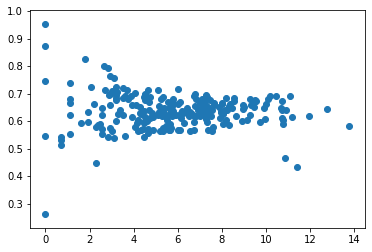

In [136]:
plt.scatter(np.log(df_country['count']), df_country['score'])

In [165]:
df_indo = df[df['country']=="ID"].copy()
df_indo['country'] = "Indonesia"
df_indo_gb = df_indo.groupby(['country', 'place_name'])
df_indo_gb = pd.DataFrame({
    'score': df_indo_gb['score'].mean(),
    'count': df_indo_gb['score'].count(),
    'lat': df_indo_gb['lat'].mean(),
    'lon': df_indo_gb['lon'].mean()
}).reset_index()
df_indo_gb['score_quantile'] = pd.qcut(df_indo_gb['score'], 10, labels=False)+1
df_indo_gb = df_indo_gb[df_indo_gb['count']>0]

In [166]:
df_indo_gb.to_csv('../data/indo_sentiment_example.csv', index=False)

In [150]:
df_indo['lang'].value_counts().head(10).reset_index()

,index,lang
0,in,88858
1,en,11128
2,und,8140
3,tl,2757
4,es,698
5,tr,548
6,ht,406
7,et,376
8,ar,305
9,pt,283


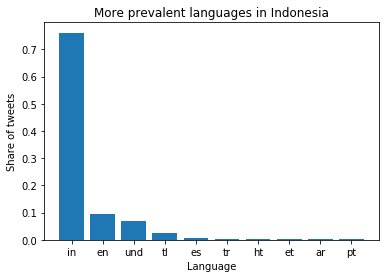

In [153]:
plt.bar(
    df_indo['lang'].value_counts(normalize=True).head(10).reset_index()['index'], 
    df_indo['lang'].value_counts(normalize=True).head(10).reset_index()['lang']
)
plt.title('More prevalent languages in Indonesia')
plt.ylabel('Share of tweets')
plt.xlabel('Language')
plt.show()

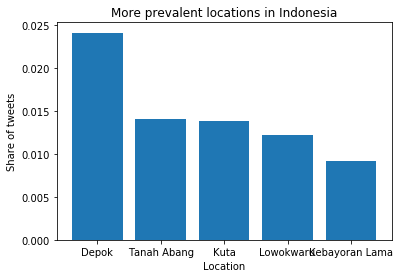

In [155]:
plt.bar(
    df_indo['place_name'].value_counts(normalize=True).head(5).reset_index()['index'], 
    df_indo['place_name'].value_counts(normalize=True).head(5).reset_index()['place_name']
)
plt.title('More prevalent locations in Indonesia')
plt.ylabel('Share of tweets')
plt.xlabel('Location')
plt.show()

In [156]:
df_indo['any_score'] = "No Score"
for var in score_vars:
    df_indo['any_score'] = np.where(df_indo[var].notnull(), "Score", df_indo['any_score'])
df_indo['any_score'] = np.where(df_indo['any_score']=="No Score", "No Score (lang="+df_indo['lang']+")", df_indo['any_score'])

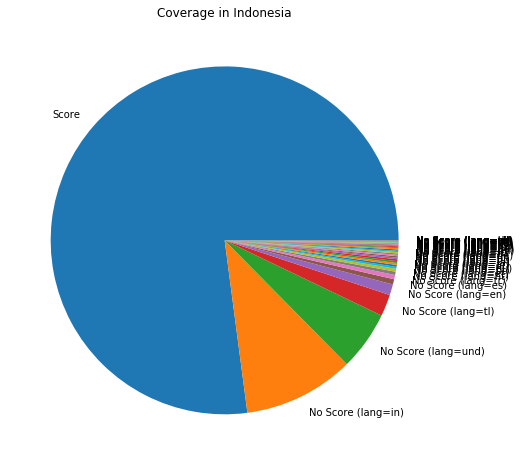

In [158]:
crosstab = df_indo['any_score'].value_counts(normalize=True).reset_index()
plt.figure(figsize=(8,8))
plt.pie(crosstab['any_score'], labels=crosstab['index'])
plt.title('Coverage in Indonesia')
plt.show()

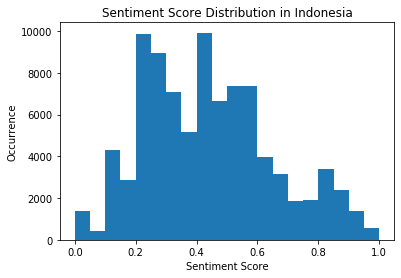

In [164]:
plt.hist(df_indo['score'], bins=20)
plt.xlabel('Sentiment Score')
plt.ylabel('Occurrence')
plt.title('Sentiment Score Distribution in Indonesia')
plt.show()

## Sandbox

In [139]:
indo_cities = pd.read_csv('../data/indo_cities.csv')
indo_cities['Place Name'] = indo_cities['Place Name'].str.replace(r',.+', '').str.strip()
indo_cities.rename(columns={'Place Name':'place_name'}, inplace=True)

FileNotFoundError: [Errno 2] File b'../data/indo_cities.csv' does not exist: b'../data/indo_cities.csv'

In [ ]:
df_indo = pd.merge(df_indo, indo_cities, how='left', on='place_name')